# **The seventh in-class-exercise (40 points in total, 10/20/2021)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (15 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [59]:
# Write your code here
# Write your code here
!pip install pyLDAvis
!pip install gensim
!pip install spacy

import nltk

import re
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LsiModel
# spacy for lemmatization
import spacy

from pprint import pprint


# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)



# Setting up nltk
# nltk.download('stopwords')


stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


In [43]:
df = pd.read_csv("https://raw.githubusercontent.com/kaziunt2022/exercise_4/main/Reviews.CSV") # Import the Reviews.CSV as pandas dataframe


In [44]:
## Cleaning the reviews
data = df.Reviews.values.tolist() # Convert each review to list
data = [re.sub('\s+', ' ', sentence) for sentence in data] # remose the line breakers
data = [re.sub("\'"," ", sentence) for sentence in data] # remocve the \'

def sent_to_words(reviews):
    """
    Input: sentence--> string
    Function: Tokenize the sentence and remove punctuations
    Output: tokenize and clean reviews
    """
    sentence = []
    for review in reviews:
        sentence.append(gensim.utils.simple_preprocess(str(review).encode('utf-8'), deacc=True))  # deacc=True removes punctuations
    return sentence
tokenize_reviews = list(sent_to_words(data))


In [45]:
## bigram and trigam mmodels 
bigram = gensim.models.Phrases(tokenize_reviews, min_count=5, threshold=100) # creat bigram phrases
bigram_model = gensim.models.phrases.Phraser(bigram) # bigram model
trigram_model = gensim.models.phrases.Phraser(gensim.models.Phrases(bigram[tokenize_reviews], threshold=100))

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [46]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(reviews): 
    """
    Input: list of lists of reviews
    Func: remove all stopwords
    Output: tokenize reviews without stop words
    """
    return [[word for word in simple_preprocess(str(review)) if word not in stop_words] for review in reviews]

def make_bigrams(reviews):
    """
    Input: tokenize reviews
    Func: make bigrams
    Output: bigrams of reviews
    """
    return [bigram_model[review] for review in reviews]

def make_trigrams(reviews):
    """
    Input: tokenize reviews
    Func: make trigrams
    Output: trigrams of bigram reviews
    """
    return [trigram_model[bigram_model[review]] for review in reviews]

def lemmatization(reviews, allowed=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """
    Input: tokenize bigram reviews
    Func: return only Noun, adj, verb, adverbs
    Output: nouns, adj, verb, adv of reviews
    """
    output_reviews= []
    for sent in reviews:
        review = nlp(" ".join(sent)) 
        output_reviews.append([token.lemma_ for token in review if token.pos_ in allowed])
    return output_reviews

In [47]:

bigrame_reviews = make_bigrams(remove_stopwords(tokenize_reviews)) # take bigram of the Reviews without stopwords

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) # initiaize the nlp english model

lemmatize_reviews = lemmatization(bigrame_reviews, ['NOUN', 'ADJ', 'VERB', 'ADV']) # nouns, adj, verb, adv of reviews


In [48]:

id2word = corpora.Dictionary(lemmatize_reviews) # Create Dictionary

corpus = [id2word.doc2bow(review) for review in lemmatize_reviews] # freq of words


In [49]:
# Create LDA model
LDA_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=20, random_state=100, update_every=1,
                                            chunksize=100, passes=10, alpha='auto', per_word_topics=True)
review_lda = LDA_model[corpus]

In [50]:
print('Perplexity: ', LDA_model.log_perplexity(corpus))  # Compute Perplexity and print it
coherence_model_lda = CoherenceModel(model=LDA_model, texts=lemmatize_reviews, dictionary=id2word, coherence='c_v') #initilize coherence model
coherence_lda = coherence_model_lda.get_coherence() #get cohernece score
print('Coherence Score: ', coherence_lda)

Perplexity:  -7.234358997237455
Coherence Score:  0.4799173353319075


In [51]:
# Check and 
def get_lda_topics(model, num_topics):
    """
    Input: LDA model, required topics
    Func: create a dataframe of topics
    Output: Pandas data frame
    """
    word_dict = {}
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20)
        word_dict['Topic ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
    return pd.DataFrame(word_dict)

get_lda_topics(LDA_model, 10)

AttributeError: ignored

            Topic 01     Topic 02   Topic 03  ...     Topic 08   Topic 09   Topic 10
0             honest        major    problem  ...         film       feel  character
1           mediocre       effort      learn  ...         well         go       also
2             script      combine      woman  ...         plot       make     really
3               chop    cinematic     decide  ...    character       even      think
4          dangerous    influence       dark  ...       little        see       much
5          landscape        score    connect  ...          bit       love      would
6              shake        shame   familiar  ...         seem        way      thing
7   high_expectation         crew       play  ...      overall      first       like
8               crap          let     master  ...         hero  character       main
9              brain         spot      other  ...       action      story     pretty
10    winter_soldier       review        art  ...       always   

In [52]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Input: 
    Dictionary of words freq --> dict
    corpus of words --> list
    reviews --> list
    limit --> int
    start --> int
    step --> int
    Func: find the coherence score for each set of topic numbers
    Output: 
    model_list --> list: list of models
    coherence_values --> float: score of coherence
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [53]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=lemmatize_reviews, start=2, limit=60, step=6)

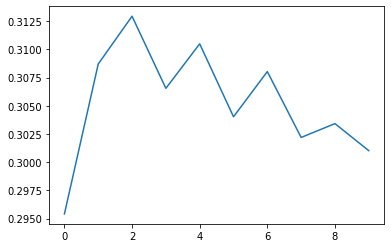

In [57]:
import matplotlib.pyplot as plt
plt.plot(coherence_values)

In [58]:
for model, cv in zip(range(2, 60, 6), coherence_values):
    print("Topics Number=", model, " has Coherence Value of", round(cv, 4))

Topics Number= 2  has Coherence Value of 0.2954
Topics Number= 8  has Coherence Value of 0.3087
Topics Number= 14  has Coherence Value of 0.3129
Topics Number= 20  has Coherence Value of 0.3065
Topics Number= 26  has Coherence Value of 0.3105
Topics Number= 32  has Coherence Value of 0.304
Topics Number= 38  has Coherence Value of 0.308
Topics Number= 44  has Coherence Value of 0.3022
Topics Number= 50  has Coherence Value of 0.3034
Topics Number= 56  has Coherence Value of 0.301


In [60]:
print("Maximum value of coherence for ascending order is: 0.3129 AT Topic Number 14\n")
LDA_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=14, random_state=100, update_every=1,
                                            chunksize=100, passes=10, alpha='auto', per_word_topics=True)
pprint(LDA_model.print_topics())

Maximum value of coherence for ascending order is: 0.3129 AT Topic Number 14

[(0,
  '0.034*"final" + 0.030*"bore" + 0.028*"monster" + 0.020*"shot" + '
  '0.017*"abomination" + 0.016*"sadly" + 0.015*"dimension" + 0.014*"carry" + '
  '0.014*"group" + 0.013*"weapon"'),
 (1,
  '0.019*"talk" + 0.018*"narrative" + 0.014*"feature" + 0.013*"combine" + '
  '0.011*"leave" + 0.010*"sequence" + 0.010*"highlight" + 0.009*"entry" + '
  '0.009*"remain" + 0.008*"nearly"'),
 (2,
  '0.028*"problem" + 0.022*"usual" + 0.018*"woman" + 0.018*"learn" + '
  '0.017*"decide" + 0.015*"theme" + 0.015*"lack" + 0.015*"couple" + '
  '0.015*"dark" + 0.014*"use"'),
 (3,
  '0.023*"look" + 0.022*"bad" + 0.018*"better" + 0.018*"try" + 0.016*"could" + '
  '0.015*"point" + 0.013*"quite" + 0.012*"high" + 0.012*"place" + '
  '0.012*"seem"'),
 (4,
  '0.023*"disappointed" + 0.020*"kinda" + 0.019*"effort" + 0.019*"hold" + '
  '0.019*"hear" + 0.018*"somehow" + 0.017*"rush" + 0.016*"mistake" + '
  '0.016*"mess" + 0.016*"guess"')

In [1]:
"""
LDA Model
1) Final monster is boring
2) Highlight combine feathures
3) Woman learn usual problems
4) Better try but look bad
5) Dissapointed effort
6) Ring kill power of mother
7) Blokbuster score but shame
8) Film instroduce use of expostion
9) Marvel movie has great characters, story with fight scenes
10) Classic choregraphy with emotional characters
11) Big star with leading performance
12) Anoying and silly
13) endgame war got obvious attention
14) Results are surprisingly poor 
"""

'\nLDA Model\n1) Final monster is boring\n2) Highlight combine feathures\n3) Woman learn usual problems\n4) Better try but look bad\n5) Dissapointed effort\n6) Ring kill power of mother\n7) Blokbuster score but shame\n8) Film instroduce use of expostion\n9) Marvel movie has great characters, story with fight scenes\n10) Classic choregraphy with emotional characters\n11) Big star with leading performance\n12) Anoying and silly\n13) endgame war got obvious attention\n14) Results are surprisingly poor \n'

## (2) (15 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [70]:
def compute_lsa_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Input: 
    Dictionary of words freq --> dict
    corpus of words --> list
    reviews --> list
    limit --> int
    start --> int
    step --> int
    Func: find the coherence score for each set of topic numbers
    Output: 
    model_list --> list: list of models
    coherence_values --> float: score of coherence
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LsiModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [71]:
LSA_model = LsiModel(corpus=corpus, id2word=id2word, chunksize=100)
review_lsa = LSA_model[corpus]

In [72]:
coherence_model_lda = CoherenceModel(model=LSA_model, texts=lemmatize_reviews, dictionary=id2word, coherence='c_v') #initilize coherence model
coherence_lda = coherence_model_lda.get_coherence() #get cohernece score
print('LSA Coherence Score: ', coherence_lda)

LSA Coherence Score:  0.23793908340553266


In [74]:
lsa_model_list, lsa_coherence_values = compute_lsa_coherence_values(dictionary=id2word, corpus=corpus, texts=lemmatize_reviews, start=2, limit=60, step=6)

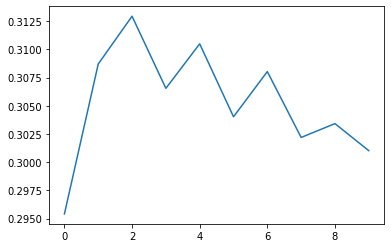

In [75]:
plt.plot(coherence_values)

In [77]:
for model, cv in zip(range(2, 60, 6), lsa_coherence_values):
    print("Topics Number=", model, " has Coherence Value of", round(cv, 4))

Topics Number= 2  has Coherence Value of 0.3306
Topics Number= 8  has Coherence Value of 0.3418
Topics Number= 14  has Coherence Value of 0.3253
Topics Number= 20  has Coherence Value of 0.3351
Topics Number= 26  has Coherence Value of 0.3126
Topics Number= 32  has Coherence Value of 0.3135
Topics Number= 38  has Coherence Value of 0.3038
Topics Number= 44  has Coherence Value of 0.3008
Topics Number= 50  has Coherence Value of 0.3033
Topics Number= 56  has Coherence Value of 0.2993


In [78]:
print("Maximum value of coherence for ascending order is: 0.3418 AT topic number 8\n")
pprint(lsa_model_list[1].print_topics())

Maximum value of coherence for ascending order is: 0.3418 AT topic number 8

[(0,
  '0.479*"movie" + 0.357*"film" + 0.257*"character" + 0.199*"good" + '
  '0.186*"scene" + 0.159*"marvel" + 0.155*"action" + 0.152*"great" + '
  '0.148*"also" + 0.145*"fight"'),
 (1,
  '0.697*"movie" + -0.617*"film" + -0.139*"also" + -0.129*"character" + '
  '-0.122*"well" + -0.071*"great" + 0.067*"marvel" + 0.063*"good" + '
  '0.063*"watch" + -0.056*"take"'),
 (2,
  '-0.547*"film" + -0.290*"movie" + 0.239*"character" + 0.207*"go" + '
  '0.178*"also" + 0.153*"really" + 0.129*"would" + -0.126*"marvel" + '
  '0.124*"ring" + 0.120*"find"'),
 (3,
  '0.619*"good" + 0.299*"scene" + -0.221*"well" + 0.203*"fight" + '
  '-0.183*"movie" + 0.169*"great" + 0.166*"also" + -0.137*"little" + '
  '-0.136*"feel" + -0.129*"character"'),
 (4,
  '0.411*"great" + 0.313*"really" + 0.263*"well" + 0.246*"character" + '
  '-0.233*"film" + -0.217*"go" + 0.167*"action" + 0.143*"also" + 0.121*"scene" '
  '+ -0.115*"good"'),
 (5,
  '-

In [ ]:
"""
LSA Model:
1) Marverl movies has great action scenes
2) Marvel movie with great characters
3) Film charcter are really good
4) Good Fighting scenes
5) Great characters with great action scenes
6) Marvel film good action scene and story
7) Great fighting scenes and really good story
"""

## (3) (10 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
# Write your answer here (no code needed for this question)
"""
LSA or you can say LSI is a much simple and fast method as compared to LDA. 
Purpose of both of them is same is to collect set of topics that can best describe the collections of sentences
But!
LSA is most simpller and only focus of frequency of words rether then there order. Although in some cases it can be a benifit but
in our case this is not as such in favour of benifit. 
LDA is a bit complex and time taking algorithem but it do a deep analysis of the system and consider words as a sequence of words. 
and in our case it's seem a bit good as compared to LSA/LSI
Coherence: LDA has high coherence value then LSA/LSI
Topics: LDA gethered more useful topics and keyword collection then LSA/LSI
Coherency: LSA topics are more coherent to each other while LDA topics are more diverse
Speed: LSA/LSI is much faster
Text: the sorted text collected by LDA is better then that collected with LSA/LSI
"""